In [1]:
import numpy as np
import pandas as pd 

## Quick Data Pre-processing

In [2]:
labels_df = pd.read_csv('/home/ashvets/train_v2.csv')

# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
            
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    
# Display head
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [3]:
# Load images

from glob import glob
image_paths = sorted(glob('/home/ashvets/train-jpg/*.jpg'))
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))

In [4]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import fbeta_score, precision_score, make_scorer, average_precision_score
from IPython.display import display
from PIL import Image

from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, Activation
from keras.layers.advanced_activations import ELU
from keras.constraints import nonneg
from keras.optimizers import SGD, Adam
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [5]:
# Build X and y arrays

common_df = labels_df.drop(['blow_down', 'conventional_mine', 'slash_burn', 'blooming',
                            'artisinal_mine', 'selective_logging'], 1)

X = []
y = []
#y_common = []
for i in range(len(image_paths)):
    img = Image.open(image_paths[i])
    x = img_to_array(img, data_format='channels_last')
    X.append(x / 255)
    y.append(labels_df[labels_df.image_name == image_names[i]].drop(['image_name',
                                                                'tags'], 1).values)
    #y_common.append(common_df[common_df.image_name == image_names[i]].drop(['image_name',
      #                                                          'tags'], 1).values)

In [14]:
X = np.array(X)
y = np.array(y).reshape(len(y),17)
#y = np.array(y_common).reshape(30000,11)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
# Function to calculate fbeta metric

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred_bin, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

In [16]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output


#function to graph accuracy, fbeta and loss for train and validation data for each epoch.
class TrainingVisualizerCallback(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        clear_output(wait=True)
        pd.DataFrame(self.history).plot()
        plt.show()

In [ ]:
del model

### Grid-Search for optimizer, activation, epochs, batch-size

In [26]:
def create_model(optimizer='sgd', activation='relu'):
    
    model = Sequential()
    model.add(Conv2D(input_shape=X[0].shape, filters=64, kernel_size=(7, 7), strides=(3,3)))
    model.add(Activation(activation))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(2,2)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3)))
    model.add(Activation(activation))
    model.add(Conv2D(filters=32, kernel_size=(3, 3)))
    model.add(Activation(activation))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3)))
    model.add(Activation(activation))
    model.add(Conv2D(filters=32, kernel_size=(3, 3)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation(activation))
    model.add(Dense(128))
    model.add(Activation(activation))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', fbeta])

    return model

model = KerasClassifier(build_fn=create_model, verbose=1)

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

batch_size = [32, 64, 128]
epochs = [3, 5, 10]
optimizer = [sgd, 'Adam']
activation = ['softmax', 'relu', 'tanh', 'elu']

param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer, activation=activation)

grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/3
5333/5333 [==============================] - 40s - loss: 0.6255 - acc: 0.8837 - fbeta: 0.6243    
Epoch 2/3
5333/5333 [==============================] - 27s - loss: 0.5141 - acc: 0.9057 - fbeta: 0.6432    
Epoch 3/3
5333/5333 [==============================] - 27s - loss: 0.6254 - acc: 0.8836 - fbeta: 0.6277    
Epoch 2/3
5333/5333 [==============================] - 27s - loss: 0.5139 - acc: 0.9064 - fbeta: 0.6438    
Epoch 3/3
5334/5334 [==============================] - 28s - loss: 0.6268 - acc: 0.8745 - fbeta: 0.6014    
Epoch 2/3
5334/5334 [==============================] - 27s - loss: 0.5153 - acc: 0.9051 - fbeta: 0.6417    
Epoch 3/3
5333/5333 [==============================] - 28s - loss: 0.6316 - acc: 0.8909 - fbeta: 0.6293    
Epoch 2/3
5333/5333 [==============================] - 28s - loss: 0.5297 - acc: 0.9057 - fbeta: 0.6432    
Epoch 3/3
5333/5333 [==============================] - 28s - loss: 0.6324 - acc: 0.8842 - fbeta: 0.6300    
Epoch 2/3
5333/5333 [=======

5333/5333 [==============================] - 26s - loss: 0.4920 - acc: 0.9064 - fbeta: 0.6438    
Epoch 5/5
5334/5334 [==============================] - 27s - loss: 0.6600 - acc: 0.8586 - fbeta: 0.6099    
Epoch 2/5
5334/5334 [==============================] - 26s - loss: 0.5912 - acc: 0.9051 - fbeta: 0.6417    
Epoch 3/5
5334/5334 [==============================] - 26s - loss: 0.5365 - acc: 0.9051 - fbeta: 0.6417    
Epoch 4/5
5334/5334 [==============================] - 26s - loss: 0.4934 - acc: 0.9051 - fbeta: 0.6417    
Epoch 5/5
5333/5333 [==============================] - 28s - loss: 0.6595 - acc: 0.8794 - fbeta: 0.6097    
Epoch 2/5
5333/5333 [==============================] - 27s - loss: 0.5996 - acc: 0.9057 - fbeta: 0.6432    
Epoch 3/5
5333/5333 [==============================] - 27s - loss: 0.5484 - acc: 0.9057 - fbeta: 0.6432    
Epoch 4/5
5333/5333 [==============================] - 27s - loss: 0.5045 - acc: 0.9057 - fbeta: 0.6432    
Epoch 5/5
5333/5333 [=================

5334/5334 [==============================] - 10s    
Epoch 1/10
5333/5333 [==============================] - 28s - loss: 0.6818 - acc: 0.7391 - fbeta: 0.5103    
Epoch 2/10
5333/5333 [==============================] - 26s - loss: 0.6442 - acc: 0.9057 - fbeta: 0.6432    
Epoch 3/10
5333/5333 [==============================] - 26s - loss: 0.6091 - acc: 0.9057 - fbeta: 0.6432    
Epoch 4/10
5333/5333 [==============================] - 26s - loss: 0.5781 - acc: 0.9057 - fbeta: 0.6432    
Epoch 5/10
5333/5333 [==============================] - 26s - loss: 0.5506 - acc: 0.9057 - fbeta: 0.6432    
Epoch 6/10
5333/5333 [==============================] - 26s - loss: 0.5262 - acc: 0.9057 - fbeta: 0.6432    
Epoch 7/10
5333/5333 [==============================] - 26s - loss: 0.5045 - acc: 0.9057 - fbeta: 0.6432    
Epoch 8/10
5333/5333 [==============================] - 26s - loss: 0.4851 - acc: 0.9057 - fbeta: 0.6432    
Epoch 9/10
5333/5333 [==============================] - 26s - loss: 0.4678 

5334/5334 [==============================] - 18s - loss: 0.2554 - acc: 0.9052 - fbeta: 0.6418    
Epoch 7/10
5334/5334 [==============================] - 18s - loss: 0.2533 - acc: 0.9053 - fbeta: 0.6417    
Epoch 8/10
5334/5334 [==============================] - 18s - loss: 0.2525 - acc: 0.9053 - fbeta: 0.6413    
Epoch 9/10
5334/5334 [==============================] - 18s - loss: 0.2512 - acc: 0.9055 - fbeta: 0.6414    
Epoch 10/10
5333/5333 [==============================] - 21s - loss: 0.2949 - acc: 0.8883 - fbeta: 0.6251    
Epoch 2/10
5333/5333 [==============================] - 18s - loss: 0.2568 - acc: 0.9050 - fbeta: 0.6437    
Epoch 3/10
5333/5333 [==============================] - 18s - loss: 0.2492 - acc: 0.9057 - fbeta: 0.6415    
Epoch 4/10
5333/5333 [==============================] - 18s - loss: 0.2423 - acc: 0.9074 - fbeta: 0.6334    
Epoch 5/10
5333/5333 [==============================] - 18s - loss: 0.2380 - acc: 0.9094 - fbeta: 0.6426    
Epoch 6/10
5333/5333 [=======

5333/5333 [==============================] - 17s - loss: 0.2372 - acc: 0.9098 - fbeta: 0.6417    
Epoch 9/10
5333/5333 [==============================] - 17s - loss: 0.2373 - acc: 0.9100 - fbeta: 0.6439    
Epoch 10/10
5334/5334 [==============================] - 21s - loss: 0.3417 - acc: 0.8657 - fbeta: 0.5946    
Epoch 2/10
5334/5334 [==============================] - 17s - loss: 0.2691 - acc: 0.9013 - fbeta: 0.6364    
Epoch 3/10
5334/5334 [==============================] - 16s - loss: 0.2598 - acc: 0.9039 - fbeta: 0.6403    
Epoch 4/10
5334/5334 [==============================] - 17s - loss: 0.2580 - acc: 0.9049 - fbeta: 0.6416    
Epoch 5/10
5334/5334 [==============================] - 17s - loss: 0.2505 - acc: 0.9054 - fbeta: 0.6407    
Epoch 6/10
5334/5334 [==============================] - 17s - loss: 0.2452 - acc: 0.9070 - fbeta: 0.6327    
Epoch 7/10
5334/5334 [==============================] - 17s - loss: 0.2445 - acc: 0.9078 - fbeta: 0.6330    
Epoch 8/10
5334/5334 [=======

5333/5333 [==============================] - 16s - loss: 0.3054 - acc: 0.8911 - fbeta: 0.6129    
Epoch 3/10
5333/5333 [==============================] - 16s - loss: 0.2844 - acc: 0.8969 - fbeta: 0.6268    
Epoch 4/10
5333/5333 [==============================] - 16s - loss: 0.2750 - acc: 0.9001 - fbeta: 0.6359    
Epoch 5/10
5333/5333 [==============================] - 16s - loss: 0.2711 - acc: 0.9009 - fbeta: 0.6334    
Epoch 6/10
5333/5333 [==============================] - 16s - loss: 0.2664 - acc: 0.9029 - fbeta: 0.6392    
Epoch 7/10
5333/5333 [==============================] - 16s - loss: 0.2653 - acc: 0.9032 - fbeta: 0.6387    
Epoch 8/10
5333/5333 [==============================] - 16s - loss: 0.2624 - acc: 0.9043 - fbeta: 0.6419    
Epoch 9/10
5333/5333 [==============================] - 16s - loss: 0.2602 - acc: 0.9048 - fbeta: 0.6422    
Epoch 10/10
5333/5333 [==============================] - 7s     
Epoch 1/10
5333/5333 [==============================] - 21s - loss: 0.6650

5334/5334 [==============================] - 18s - loss: 0.2424 - acc: 0.9052 - fbeta: 0.6338    
Epoch 10/10
5334/5334 [==============================] - 8s     
Epoch 1/10
5333/5333 [==============================] - 24s - loss: 0.2959 - acc: 0.8906 - fbeta: 0.6182    
Epoch 2/10
5333/5333 [==============================] - 18s - loss: 0.2724 - acc: 0.9021 - fbeta: 0.6316    
Epoch 3/10
5333/5333 [==============================] - 18s - loss: 0.2670 - acc: 0.9040 - fbeta: 0.6378    
Epoch 4/10
5333/5333 [==============================] - 18s - loss: 0.2649 - acc: 0.9047 - fbeta: 0.6404    
Epoch 5/10
5333/5333 [==============================] - 18s - loss: 0.2641 - acc: 0.9052 - fbeta: 0.6417    
Epoch 6/10
5333/5333 [==============================] - 18s - loss: 0.2625 - acc: 0.9056 - fbeta: 0.6426    
Epoch 7/10
5333/5333 [==============================] - 18s - loss: 0.2606 - acc: 0.9057 - fbeta: 0.6432    
Epoch 8/10
5333/5333 [==============================] - 18s - loss: 0.2597

5334/5334 [==============================] - 23s - loss: 0.3104 - acc: 0.8840 - fbeta: 0.6048    
Epoch 2/10
5334/5334 [==============================] - 17s - loss: 0.2781 - acc: 0.8975 - fbeta: 0.6184    
Epoch 3/10
5334/5334 [==============================] - 17s - loss: 0.2720 - acc: 0.9010 - fbeta: 0.6246    
Epoch 4/10
5334/5334 [==============================] - 17s - loss: 0.2685 - acc: 0.9029 - fbeta: 0.6311    
Epoch 5/10
5334/5334 [==============================] - 17s - loss: 0.2659 - acc: 0.9038 - fbeta: 0.6346    
Epoch 6/10
5334/5334 [==============================] - 17s - loss: 0.2639 - acc: 0.9042 - fbeta: 0.6338    
Epoch 7/10
5334/5334 [==============================] - 17s - loss: 0.2605 - acc: 0.9042 - fbeta: 0.6295    
Epoch 8/10
5334/5334 [==============================] - 17s - loss: 0.2629 - acc: 0.9044 - fbeta: 0.6362    
Epoch 9/10
5334/5334 [==============================] - 17s - loss: 0.2531 - acc: 0.9061 - fbeta: 0.6327    
Epoch 10/10
5333/5333 [=======

5333/5333 [==============================] - 16s - loss: 0.2753 - acc: 0.8998 - fbeta: 0.6279    
Epoch 7/10
5333/5333 [==============================] - 16s - loss: 0.2740 - acc: 0.9011 - fbeta: 0.6293    
Epoch 8/10
5333/5333 [==============================] - 16s - loss: 0.2713 - acc: 0.9012 - fbeta: 0.6298    
Epoch 9/10
5333/5333 [==============================] - 16s - loss: 0.2711 - acc: 0.9026 - fbeta: 0.6316    
Epoch 10/10
5333/5333 [==============================] - 7s     
Epoch 1/10
5333/5333 [==============================] - 23s - loss: 0.4350 - acc: 0.8167 - fbeta: 0.5508    
Epoch 2/10
5333/5333 [==============================] - 16s - loss: 0.2936 - acc: 0.8982 - fbeta: 0.6242    
Epoch 3/10
5333/5333 [==============================] - 16s - loss: 0.2844 - acc: 0.8983 - fbeta: 0.6251    
Epoch 4/10
5333/5333 [==============================] - 16s - loss: 0.2815 - acc: 0.8994 - fbeta: 0.6277    
Epoch 5/10
5333/5333 [==============================] - 16s - loss: 0.2805

5333/5333 [==============================] - 26s - loss: 0.2889 - acc: 0.8915 - fbeta: 0.6215    
Epoch 2/3
5333/5333 [==============================] - 18s - loss: 0.2533 - acc: 0.9063 - fbeta: 0.6357    
Epoch 3/3
5334/5334 [==============================] - 26s - loss: 0.3018 - acc: 0.8852 - fbeta: 0.6084    
Epoch 2/3
5334/5334 [==============================] - 19s - loss: 0.2536 - acc: 0.9052 - fbeta: 0.6375    
Epoch 3/3
5333/5333 [==============================] - 26s - loss: 0.3141 - acc: 0.8769 - fbeta: 0.5943    
Epoch 2/5
5333/5333 [==============================] - 18s - loss: 0.2665 - acc: 0.9026 - fbeta: 0.6373    
Epoch 3/5
5333/5333 [==============================] - 18s - loss: 0.2593 - acc: 0.9043 - fbeta: 0.6390    
Epoch 4/5
5333/5333 [==============================] - 18s - loss: 0.2539 - acc: 0.9053 - fbeta: 0.6427    
Epoch 5/5
5333/5333 [==============================] - 25s - loss: 0.3218 - acc: 0.8766 - fbeta: 0.6048    
Epoch 2/5
5333/5333 [=================

5333/5333 [==============================] - 25s - loss: 0.3125 - acc: 0.8795 - fbeta: 0.6078    
Epoch 2/5
5333/5333 [==============================] - 17s - loss: 0.2569 - acc: 0.9041 - fbeta: 0.6337    
Epoch 3/5
5333/5333 [==============================] - 17s - loss: 0.2456 - acc: 0.9080 - fbeta: 0.6482    
Epoch 4/5
5333/5333 [==============================] - 17s - loss: 0.2457 - acc: 0.9085 - fbeta: 0.6476    
Epoch 5/5
5334/5334 [==============================] - 24s - loss: 0.3140 - acc: 0.8785 - fbeta: 0.5936    
Epoch 2/5
5334/5334 [==============================] - 17s - loss: 0.2581 - acc: 0.9025 - fbeta: 0.6303    
Epoch 3/5
5334/5334 [==============================] - 17s - loss: 0.2493 - acc: 0.9067 - fbeta: 0.6424    
Epoch 4/5
5334/5334 [==============================] - 17s - loss: 0.2443 - acc: 0.9074 - fbeta: 0.6461    
Epoch 5/5
5333/5333 [==============================] - 25s - loss: 0.3479 - acc: 0.8594 - fbeta: 0.5782    
Epoch 2/10
5333/5333 [================

5333/5333 [==============================] - 26s - loss: 0.4496 - acc: 0.7892 - fbeta: 0.5074    
Epoch 2/10
5333/5333 [==============================] - 16s - loss: 0.2916 - acc: 0.8957 - fbeta: 0.6234    
Epoch 3/10
5333/5333 [==============================] - 17s - loss: 0.2807 - acc: 0.8991 - fbeta: 0.6263    
Epoch 4/10
5333/5333 [==============================] - 16s - loss: 0.2745 - acc: 0.9009 - fbeta: 0.6316    
Epoch 5/10
5333/5333 [==============================] - 17s - loss: 0.2713 - acc: 0.9018 - fbeta: 0.6323    
Epoch 6/10
5333/5333 [==============================] - 17s - loss: 0.2669 - acc: 0.9027 - fbeta: 0.6341    
Epoch 7/10
5333/5333 [==============================] - 17s - loss: 0.2640 - acc: 0.9039 - fbeta: 0.6365    
Epoch 8/10
5333/5333 [==============================] - 17s - loss: 0.2623 - acc: 0.9041 - fbeta: 0.6375    
Epoch 9/10
5333/5333 [==============================] - 17s - loss: 0.2615 - acc: 0.9045 - fbeta: 0.6383    
Epoch 10/10
5333/5333 [=======

Best: 0.914949 using {'optimizer': 'Adam', 'epochs': 10, 'activation': 'elu', 'batch_size': 64} (smaller smaple than final model)

### GridSearchCV for Dropout rate, learning rate and momentum

In [ ]:
def create_model(dropout_rate=0.0, learn_rate=0.01):
    
    model = Sequential()
    model.add(Conv2D(input_shape=X[0].shape, filters=64, kernel_size=(3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(filters=32, kernel_size=(3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(filters=32, kernel_size=(3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('elu'))
    model.add(Dense(128))
    model.add(Activation('elu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(17, activation='sigmoid'))
    
    optimizer = Adam(lr=learn_rate)
              
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', fbeta])

    return model

model = KerasClassifier(build_fn=create_model, verbose=1)

dropout_rate = [0.1, 0.3, 0.5]
learn_rate = [.0001, 0.001, 0.01, .1]
#momentum = [0.6, 0.8, 0.9]
batch_size = [64]
epochs = [3]
              
param_grid = dict(dropout_rate=dropout_rate, batch_size=batch_size,
                  learn_rate=learn_rate, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/3
5333/5333 [==============================] - 163s - loss: 0.2694 - acc: 0.8984 - fbeta: 0.6380   
Epoch 2/3
5333/5333 [==============================] - 154s - loss: 0.2418 - acc: 0.9070 - fbeta: 0.6508   
Epoch 3/3
5333/5333 [==============================] - 47s    
Epoch 1/3
5333/5333 [==============================] - 154s - loss: 0.2736 - acc: 0.8946 - fbeta: 0.6285   
Epoch 2/3
5333/5333 [==============================] - 154s - loss: 0.2430 - acc: 0.9061 - fbeta: 0.6505   
Epoch 3/3
5333/5333 [==============================] - 47s    
Epoch 1/3
5334/5334 [==============================] - 157s - loss: 0.2723 - acc: 0.8938 - fbeta: 0.6352   
Epoch 2/3
5334/5334 [==============================] - 154s - loss: 0.2391 - acc: 0.9080 - fbeta: 0.6526   
Epoch 3/3
5334/5334 [==============================] - 47s    
Epoch 1/3
5333/5333 [==============================] - 154s - loss: 0.4514 - acc: 0.8608 - fbeta: 0.6003   
Epoch 2/3
5333/5333 [==============================] - 

### Simple Neural Network Model

In [ ]:
del model_simple

In [21]:
model_simple = Sequential()
model_simple.add(Flatten(input_shape=X[0].shape))
model_simple.add(Dense(17, activation='sigmoid'))

model_simple.summary()

model_simple.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', fbeta])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 17)                4456465   
Total params: 4,456,465.0
Trainable params: 4,456,465.0
Non-trainable params: 0.0
_________________________________________________________________


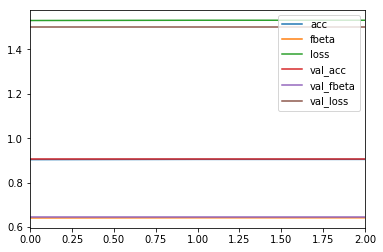

29144/29144 [==============================] - 24s - loss: 1.5306 - acc: 0.9048 - fbeta: 0.6423 - val_loss: 1.5020 - val_acc: 0.9066 - val_fbeta: 0.6460


In [22]:
model_simple.fit(X_train, y_train, epochs=3, verbose=1, validation_split = .1, batch_size=64,
            callbacks=[TrainingVisualizerCallback()])

## Best Model

In [13]:
del model_best

In [25]:
model_best = Sequential()
model_best.add(Conv2D(input_shape=X[0].shape, filters=64, kernel_size=(3, 3), padding='same'))
model_best.add(Activation('elu'))
model_best.add(Conv2D(filters=64, kernel_size=(3, 3)))
model_best.add(Activation('elu'))
model_best.add(MaxPooling2D(pool_size=(2, 2)))
model_best.add(Dropout(0.1))

model_best.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model_best.add(Activation('elu'))
model_best.add(Conv2D(filters=32, kernel_size=(3, 3)))
model_best.add(Activation('elu'))
model_best.add(MaxPooling2D(pool_size=(2, 2)))
model_best.add(Dropout(0.1))

model_best.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model_best.add(Activation('elu'))
model_best.add(Conv2D(filters=32, kernel_size=(3, 3)))
model_best.add(Activation('elu'))
model_best.add(MaxPooling2D(pool_size=(2, 2)))
model_best.add(Dropout(0.1))

model_best.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model_best.add(Activation('elu'))
model_best.add(Conv2D(filters=32, kernel_size=(3, 3)))
model_best.add(Activation('elu'))
model_best.add(MaxPooling2D(pool_size=(2, 2)))
model_best.add(Dropout(0.1))

model_best.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model_best.add(Activation('elu'))
model_best.add(Conv2D(filters=32, kernel_size=(3, 3)))
model_best.add(Activation('elu'))
model_best.add(MaxPooling2D(pool_size=(2, 2)))
model_best.add(Dropout(0.25))

model_best.add(Flatten())
model_best.add(Dense(256))
model_best.add(Activation('elu'))
model_best.add(Dense(128))
model_best.add(Activation('elu'))
model_best.add(Dropout(0.5))
model_best.add(Dense(17, activation='sigmoid'))

adam = Adam(lr=.0001)

model_best.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', fbeta])

model_best.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 256, 256, 64)      2368      
_________________________________________________________________
activation_25 (Activation)   (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 254, 254, 64)      36928     
_________________________________________________________________
activation_26 (Activation)   (None, 254, 254, 64)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 127, 127, 64)      36928     
__________

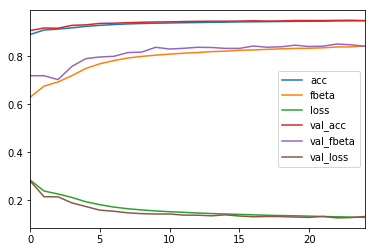

29144/29144 [==============================] - 1086s - loss: 0.1283 - acc: 0.9493 - fbeta: 0.8435 - val_loss: 0.1320 - val_acc: 0.9494 - val_fbeta: 0.8427


In [26]:
model_best.fit(X_train, y_train, epochs=25, verbose=1, validation_split = .1, batch_size=64,
            callbacks=[TrainingVisualizerCallback()])

optiimizer = sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [27]:
predictions = model_best.predict(X_test)

y_true, y_pred = y_test, predictions
# ensure, that y_true has at least one 1, because sklearn's fbeta can't handle all-zeros
y_true[:, 0] += 1 - y_true.sum(axis=1).clip(0, 1)

fbeta_keras = fbeta(K.variable(y_true), K.variable(y_pred)).eval(session=K.get_session())
fbeta_sklearn = fbeta_score(y_true, np.round(y_pred), beta=2, average='samples')

print('Scores are {:.3f} (sklearn) and {:.3f} (keras)'.format(fbeta_sklearn, fbeta_keras))

Scores are 0.845 (sklearn) and 0.845 (keras)


/home/ashvets/miniconda3/envs/opencv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


### Model without the 6 least frequent labels

In [ ]:
del model_common

In [9]:
model_common = Sequential()
model_common.add(Conv2D(input_shape=X[0].shape, filters=64, kernel_size=(3, 3), padding='same'))
model_common.add(Activation('elu'))
model_common.add(Conv2D(filters=64, kernel_size=(3, 3)))
model_common.add(Activation('elu'))
model_common.add(MaxPooling2D(pool_size=(2, 2)))
model_common.add(Dropout(0.1))

model_common.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model_common.add(Activation('elu'))
model_common.add(Conv2D(filters=32, kernel_size=(3, 3)))
model_common.add(Activation('elu'))
model_common.add(MaxPooling2D(pool_size=(2, 2)))
model_common.add(Dropout(0.1))

model_common.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model_common.add(Activation('elu'))
model_common.add(Conv2D(filters=32, kernel_size=(3, 3)))
model_common.add(Activation('elu'))
model_common.add(MaxPooling2D(pool_size=(2, 2)))
model_common.add(Dropout(0.25))

model_common.add(Flatten())
model_common.add(Dense(256))
model_common.add(Activation('elu'))
model_common.add(Dense(128))
model_common.add(Activation('elu'))
model_common.add(Dropout(0.5))
model_common.add(Dense(11, activation='sigmoid'))

adam = Adam(lr=.0001)

model_common.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', fbeta])

model_common.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      2368      
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 254, 254, 64)      36928     
_________________________________________________________________
activation_2 (Activation)    (None, 254, 254, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 127, 127, 64)      36928     
__________

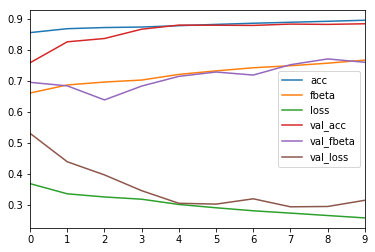

21600/21600 [==============================] - 801s - loss: 0.2570 - acc: 0.8951 - fbeta: 0.7664 - val_loss: 0.3139 - val_acc: 0.8837 - val_fbeta: 0.7594


In [10]:
model_common.fit(X_train, y_train, epochs=10, verbose=1, validation_split = .1, batch_size=64,
            callbacks=[TrainingVisualizerCallback()])

Most_common: accuracy: .8951, fbeta: .7664. Size: 30,000, epochs: 10

I did not run the model_common for the same number of epochs as model_best, but the fbeta score after 10 epochs is better than the other models were after the same number of epochs. This could signify that the less frequent labels do lower the performance of the model. However, the effect is not that drastic which makes me believe most of my error is due to a portion of the training images being labeled incorrectly. 